In [1]:
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import matplotlib as mpl

import raddetect as rd

In [2]:
from scipy.stats import crystalball
from scipy.stats import norm

In [3]:
# It works only in the MPIK network
monalpha = rd.MonalphaAnalysis(filename='Mn29072024', energy_calibration=[0.13942, 23.36])

Retrieving data from https://radon-srv1.mpi-hd.mpg.de/coating_db/resultfiles/Mn29072024/mn29072024.root


/home/volta/Documents/MPIK/RadDetect/raddetect/monalpha/monalpha_analysis.py:39: UserWarning: energy_calibration is not None. this will affect the MCA range selection. Be caferul!
  warnings.warn("energy_calibration is not None. this will affect the MCA range selection. Be caferul!")


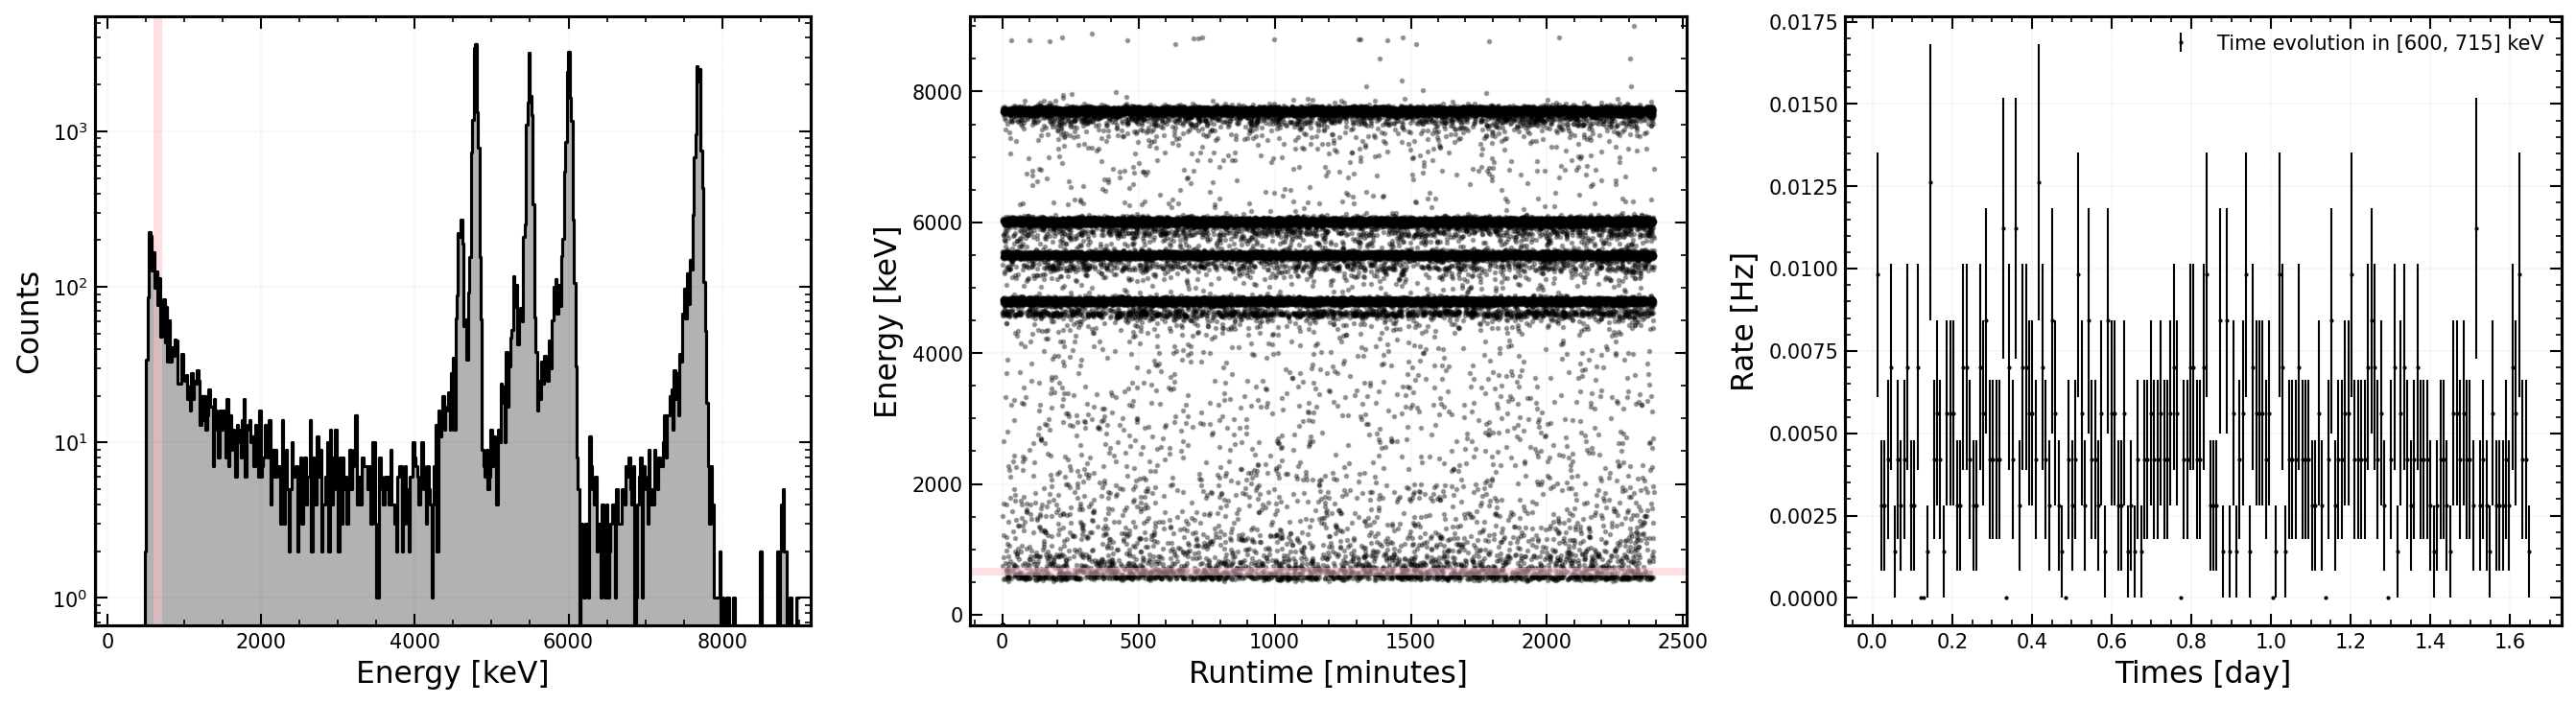

In [5]:
monalpha.get_base_plot(n_mca=500, n_timestamp=200)

In [ ]:
class Model:
    def __init__(self, 
                x,
                # beta1, m1,
                loc1, scale1, A1, 
                beta2, m2, loc2, scale2, A2
                ):
        self.x = x
        #self.beta1 = beta1
        #self.m1 = m1
        self.loc1 = loc1
        self.scale1 = scale1
        self.A1 = A1
        self.beta2 = beta2
        self.m2 = m2
        self.loc2 = loc2
        self.scale2 = scale2
        self.A2 = A2
        self.compute_terms()

    def compute_terms(self):
        self.norm_1 = self.A1 * norm.pdf(self.x, loc=self.loc1, scale=self.scale1)
        # self.crystalball_1 = self.A1 * crystalball.pdf(self.x, self.beta1, self.m1, loc=self.loc1, scale=self.scale1)
        self.crystalball_2 = self.A2 * crystalball.pdf(self.x, self.beta2, self.m2, loc=self.loc2, scale=self.scale2) 

    def sum_terms(self):
        return self.norm_1 + self.crystalball_2

    @staticmethod
    def total_model(x, 
                    # beta1, m1, 
                    loc1, scale1, A1, 
                    beta2, m2, loc2, scale2, A2
                    ):
        model_instance = Model(x, 
                            # beta1, m1, 
                            loc1, scale1, A1, 
                            beta2, m2, loc2, scale2, A2
                            )
        return model_instance.sum_terms()

init = {
    # 'beta1': 1, 'm1': 2, 
    'loc1': 665, 'scale1': 3, 'A1': 100,
    'beta2': 1, 'm2': 2, 'loc2': 690, 'scale2': 3, 'A2': 3500
}

fixed = {
    # 'beta1': False, 'm1': False, 
    'loc1': False, 'scale1': False, 'A1': False, 
    'beta2': False, 'm2': False, 'loc2': False, 'scale2': False, 'A2': False,    
}

_MCA_range = [655, 710]
_MCA_counts_limit = 1
m = monalpha.get_mca_spectrum_fitting_object(model=Model, init=init, MCA_range=_MCA_range, MCA_counts_limit=_MCA_counts_limit, fixed=fixed)
m.migrad()
# m.minos()
# m.hesse()

In [ ]:
data, channels = monalpha.get_mca_histogram(MCA_range=[0, 1300])
_data, _channels = monalpha.get_mca_histogram(MCA_range=_MCA_range)
mask = (_data > _MCA_counts_limit)
_data = _data[mask]
_channels = _channels[mask]
_model = Model(_channels, *np.array(m.values))

x = np.arange(0, 1300, 0.1)
model = Model(x, *np.array(m.values))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), dpi=200, sharex=True, gridspec_kw={'height_ratios':[2,1], 'hspace': 0.05})

ax1.errorbar(channels, data, yerr=np.sqrt(data), lw=0, marker='o', color='black', ms=3, elinewidth=1, alpha=0.25)
ax1.errorbar(_channels, _data, yerr=np.sqrt(_data), lw=0, marker='o', color='black', ms=3, elinewidth=1, alpha=1)

l = ax1.plot(x, model.sum_terms(), ls='-', color='darkred', zorder=5)
ax1.plot(x, model.norm_1, ls='--', lw=1.5, color='red', alpha=0.5, zorder=3)
ax1.plot(x, model.crystalball_2, ls='--', lw=1.5, color='orange', alpha=0.5, zorder=3)

ax2.plot(_channels, (_data - _model.sum_terms()) / np.sqrt(_data), lw=0, marker='.', color=l[0].get_color())

ax2.axhspan(-2, 2, color='yellow', lw=0, alpha=0.25)
ax2.axhspan(-1, 1, color='green', lw=0, alpha=0.35)

ax1.set_yscale('log')
ax1.set_ylim(1e0, 1e4)
ax1.set_xlim(400, 1300)

ax1.grid()

# ax2.set_ylim(-5, 50)
ax2.grid()

ax2.set_xlabel('MCA channel')
ax1.set_ylabel('Counts')
ax2.set_ylabel('Residual [$\sigma$]')
        
plt.tight_layout()
plt.show()

# Activity estimation

In [ ]:
tot_counts = np.sum(_data) * np.diff(_channels)[0]
tot_counts_err = np.sqrt(np.sum(_data) * np.diff(_channels)[0])
livetime = ( max(monalpha.timestamp) - min(monalpha.timestamp) ) # this is not corrected for the deadtime
measured_activity = tot_counts / livetime
measured_activity_err = tot_counts_err / livetime

print(f'Activity given data in {_MCA_range}: {measured_activity:.4f} +/- {measured_activity_err:.4f} Hz')

In [ ]:
# see here for all the geometrical efficiencies: https://docs.google.com/spreadsheets/d/1N4GCnCQyMScjAJV0-CRPdfsBdWHai_owmR4s_UxL4Is/edit?gid=0#gid=0
# carefull that they might be outdated !!
eff = 2.93/2/100
eff_err = 0.02/2/100

true_activity = measured_activity / eff
true_activity_err = np.sqrt( (measured_activity_err/measured_activity)**2 + eff_err**2  ) 

print(f'Corrected activity: {true_activity:.3f} +/- {true_activity_err:.3f} Bq')